<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px">

## Timeseries modeling with LSTM neural networks

Week 10 | Lesson 4.1

---

Modeling timeseries with neural network architecture is a widely growing trend. In particular, the Long Short Term Memory (LSTM) recurrent neural network is a common choice as it is designed to maintain "context" or memory of temporal events.

In this lecture/lab we will be building an LSTM using Keras to forecast timeseries data. 

[The lecture is based very heavily on this tutorial](http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) which provides a great introduction to building a simple LSTM for timeseries forecasting.

Two great resources on neural network architecture and LSTMs can be found here as well:

http://deeplearning4j.org/lstm.html#a-beginners-guide-to-recurrent-networks-and-lstms

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

---

### Load standard packages and the unemployment timeseries dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
data = pd.read_csv('seasonally-adjusted-quarterly-us.csv')

In [4]:
data.columns = ['year_quarter', 'unemployment_rate']
data['unemployment_rate'] = data['unemployment_rate'].map(lambda x: float(str(x).replace('%','')))
data.dropna(inplace=True)

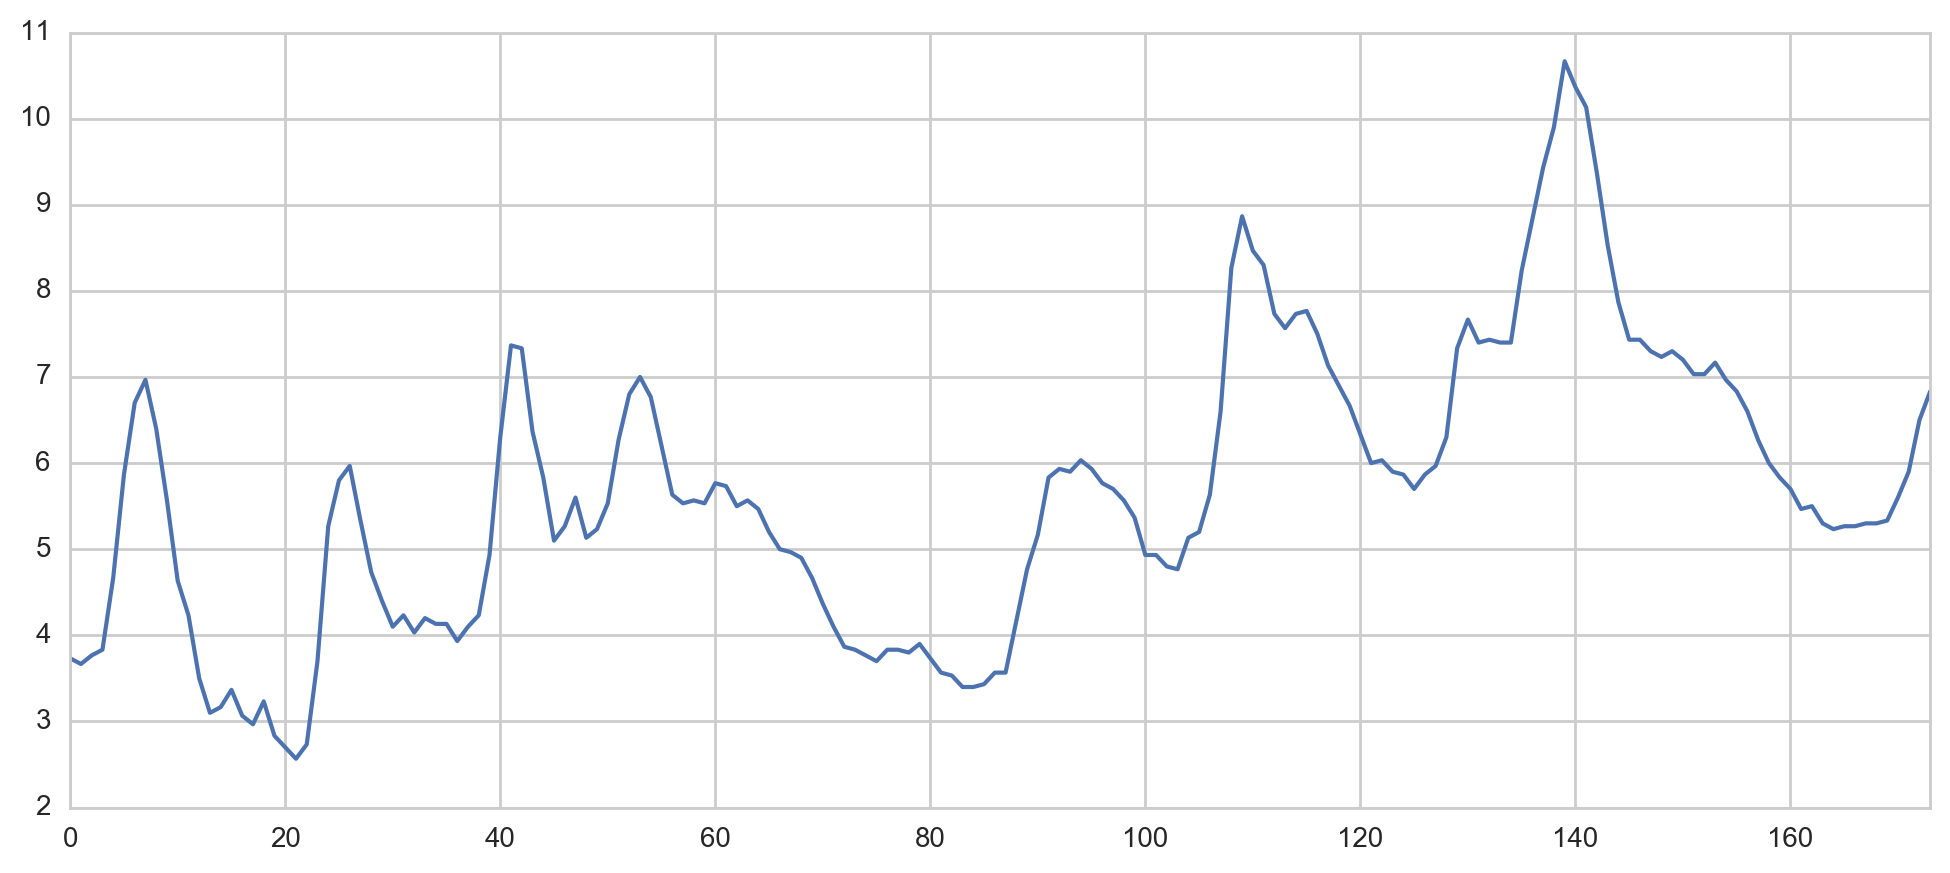

In [5]:
data.unemployment_rate.plot(lw=1.5, figsize=(12,5))

---

### Load Keras modules

We are going to be loading four classes from Keras:

- **`Sequential`** is the model that will house our neural network layers. It stacks together the input, "hidden" and output layers of the network.
- **`Dense`** is a standard fully-connected neural network layer where each node as inputs/output connections to every node in the layers it is connected to.
- **`LSTM`** is the Long Short Term Memory recurrent neural network layer. This will house our LSTM "neurons" or "cells".

We are also importing `MinMaxScaler` from sklearn since inputs to the LSTM perform better if they are kept on a 0-1 scale.

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


---

### Pull out the unemployment rate and scale it.

Keep it as a DataFrame rather than a series object for now.

In [7]:
urate = data[['unemployment_rate']]
urate.head(2)

,unemployment_rate
0,3.733
1,3.667


In [8]:
mms = MinMaxScaler()
urate = mms.fit_transform(urate)

In [9]:
urate[0:3,:]

array([[ 0.14395062],
       [ 0.13580247],
       [ 0.14814815]])

---

### Split the timeseries into 50% train/test splits

In [10]:
urate.shape

(174, 1)

In [11]:
train, test = urate[:urate.shape[0]/2, :], urate[urate.shape[0]/2:, :]

In [12]:
print train.shape, test.shape

(87, 1) (87, 1)


---

### Write a function to create our predictor and target data

Our function will need to create a Y target and X predictor. The X predictor matrix will be the shifted versions of Y, our target unemployment timeseries.

Make a function with two arguments:

1. The timeseries data.
2. The number of lags of the timeseries to have as predictors.


This default will create a dataset where X is the unemployment rate a given time (t) and Y is the unemployment rate at the next time (t + 1). In other words, at the default lag of 1 X will just be the unemployment timeseries of Y shifted back by 1.

Make sure that in the end X and Y are of the same length!

In [13]:
tmp = train.ravel()[0:10]
tmp

array([ 0.14395062,  0.13580247,  0.14814815,  0.1562963 ,  0.25925926,
        0.40740741,  0.51024691,  0.54320988,  0.47320988,  0.37037037])

In [14]:
lag = 3
y = tmp[3:]
y

array([ 0.1562963 ,  0.25925926,  0.40740741,  0.51024691,  0.54320988,
        0.47320988,  0.37037037])

In [15]:
x1 = tmp[1:]
x1[:len(y)]

array([ 0.13580247,  0.14814815,  0.1562963 ,  0.25925926,  0.40740741,
        0.51024691,  0.54320988])

In [16]:
for i in range(1):
    print i


0


In [17]:
def create_XY(timeseries, lag=1):
    ts = timeseries.ravel()
    y = ts[lag:]
    X = []
    for i in range(lag):
        X.append(ts[i:len(y)+i])
    return np.array(X).T, y

In [18]:
X, y = create_XY(tmp, lag=2)
y

array([ 0.14814815,  0.1562963 ,  0.25925926,  0.40740741,  0.51024691,
        0.54320988,  0.47320988,  0.37037037])

In [19]:
X

array([[ 0.14395062,  0.13580247],
       [ 0.13580247,  0.14814815],
       [ 0.14814815,  0.1562963 ],
       [ 0.1562963 ,  0.25925926],
       [ 0.25925926,  0.40740741],
       [ 0.40740741,  0.51024691],
       [ 0.51024691,  0.54320988],
       [ 0.54320988,  0.47320988]])

---

### Create training and testing data for a lag of 1

Again, this means our X will just have 1 column.

In [20]:
trainX, trainY = create_XY(train, lag=1)
testX, testY = create_XY(test, lag=1)

In [21]:
trainX.shape

(86, 1)

In [22]:
trainY[0:10]

array([ 0.13580247,  0.14814815,  0.1562963 ,  0.25925926,  0.40740741,
        0.51024691,  0.54320988,  0.47320988,  0.37037037,  0.25506173])

In [23]:
trainX[0:10]

array([[ 0.14395062],
       [ 0.13580247],
       [ 0.14814815],
       [ 0.1562963 ],
       [ 0.25925926],
       [ 0.40740741],
       [ 0.51024691],
       [ 0.54320988],
       [ 0.47320988],
       [ 0.37037037]])

---

### Reshaping the data to work with the LSTM

The layout the LSTM expects for our data is:

    [samples, time steps, features]
    
A 3D matrix.

Currently our X predictor matrix is in the form 

    [samples, features]
    
Where we have one time step per feature per sample.

You can use the `np.reshape()` command to turn your 2D X matrix into a 3D matrix that works for the LSTM matrix. We will talk about the "time step" dimension more down the line.

In [24]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [25]:
trainX.shape

(86, 1, 1)

---

### Constructing the Keras model

Our LSTM model will be constructed in three parts:

```python
model = Sequential()
```
    
Will initialize the sequential layer-to-layer neural network model.

```python
model.add(LSTM(4, input_dim=1))
```

Will add an LSTM layer with 4 blocks/cells/neurons. We specify the `input_dim` to be the same dimensions as our number of features. In our current scenario this is just our single timeseries of the 1-lag previous unemployment rate.

```python
model.add(Dense(1))
```

Will add the output layer as a layer of one neuron that is fully connected to all of the previous LSTM cells.

In [26]:
model = Sequential()
model.add(LSTM(4, input_dim=1))
model.add(Dense(1))

---

### Fit the LSTM model

We can fit the model with these commands:

```python
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)
```

Which will use the squared error loss (regression) and fit the data over 100 "epochs", or passes over the training data. It makes multiple passes because these LSTM neural networks learn according to a learning rate (which we have not specified).

In [27]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
4s - loss: 0.0372
Epoch 2/100
1s - loss: 0.0156
Epoch 3/100
1s - loss: 0.0115
Epoch 4/100
1s - loss: 0.0104
Epoch 5/100
1s - loss: 0.0095
Epoch 6/100
1s - loss: 0.0087
Epoch 7/100
1s - loss: 0.0079
Epoch 8/100
0s - loss: 0.0072
Epoch 9/100
1s - loss: 0.0066
Epoch 10/100
1s - loss: 0.0060
Epoch 11/100
1s - loss: 0.0054
Epoch 12/100
1s - loss: 0.0050
Epoch 13/100
1s - loss: 0.0047
Epoch 14/100
1s - loss: 0.0043
Epoch 15/100
1s - loss: 0.0040
Epoch 16/100
1s - loss: 0.0038
Epoch 17/100
1s - loss: 0.0038
Epoch 18/100
1s - loss: 0.0036
Epoch 19/100
1s - loss: 0.0034
Epoch 20/100
1s - loss: 0.0034
Epoch 21/100
1s - loss: 0.0033
Epoch 22/100
1s - loss: 0.0034
Epoch 23/100
1s - loss: 0.0033
Epoch 24/100
1s - loss: 0.0033
Epoch 25/100
1s - loss: 0.0033
Epoch 26/100
1s - loss: 0.0033
Epoch 27/100
1s - loss: 0.0033
Epoch 28/100
1s - loss: 0.0032
Epoch 29/100
0s - loss: 0.0033
Epoch 30/100
0s - loss: 0.0033
Epoch 31/100
0s - loss: 0.0033
Epoch 32/100
1s - loss: 0.0033
Epoch 33/100
0s -

---

### Plot the original data, the training predictions and the testing predictions

You can predict from a Keras model much like with a sklearn model:

```python
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
```

Make sure you lag the data forward for training and testing!

In [28]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [29]:
print urate.shape, trainPredict.shape, testPredict.shape

(174, 1) (86, 1) (86, 1)


In [30]:
urate = MinMaxScaler().fit_transform(data[['unemployment_rate']].values)

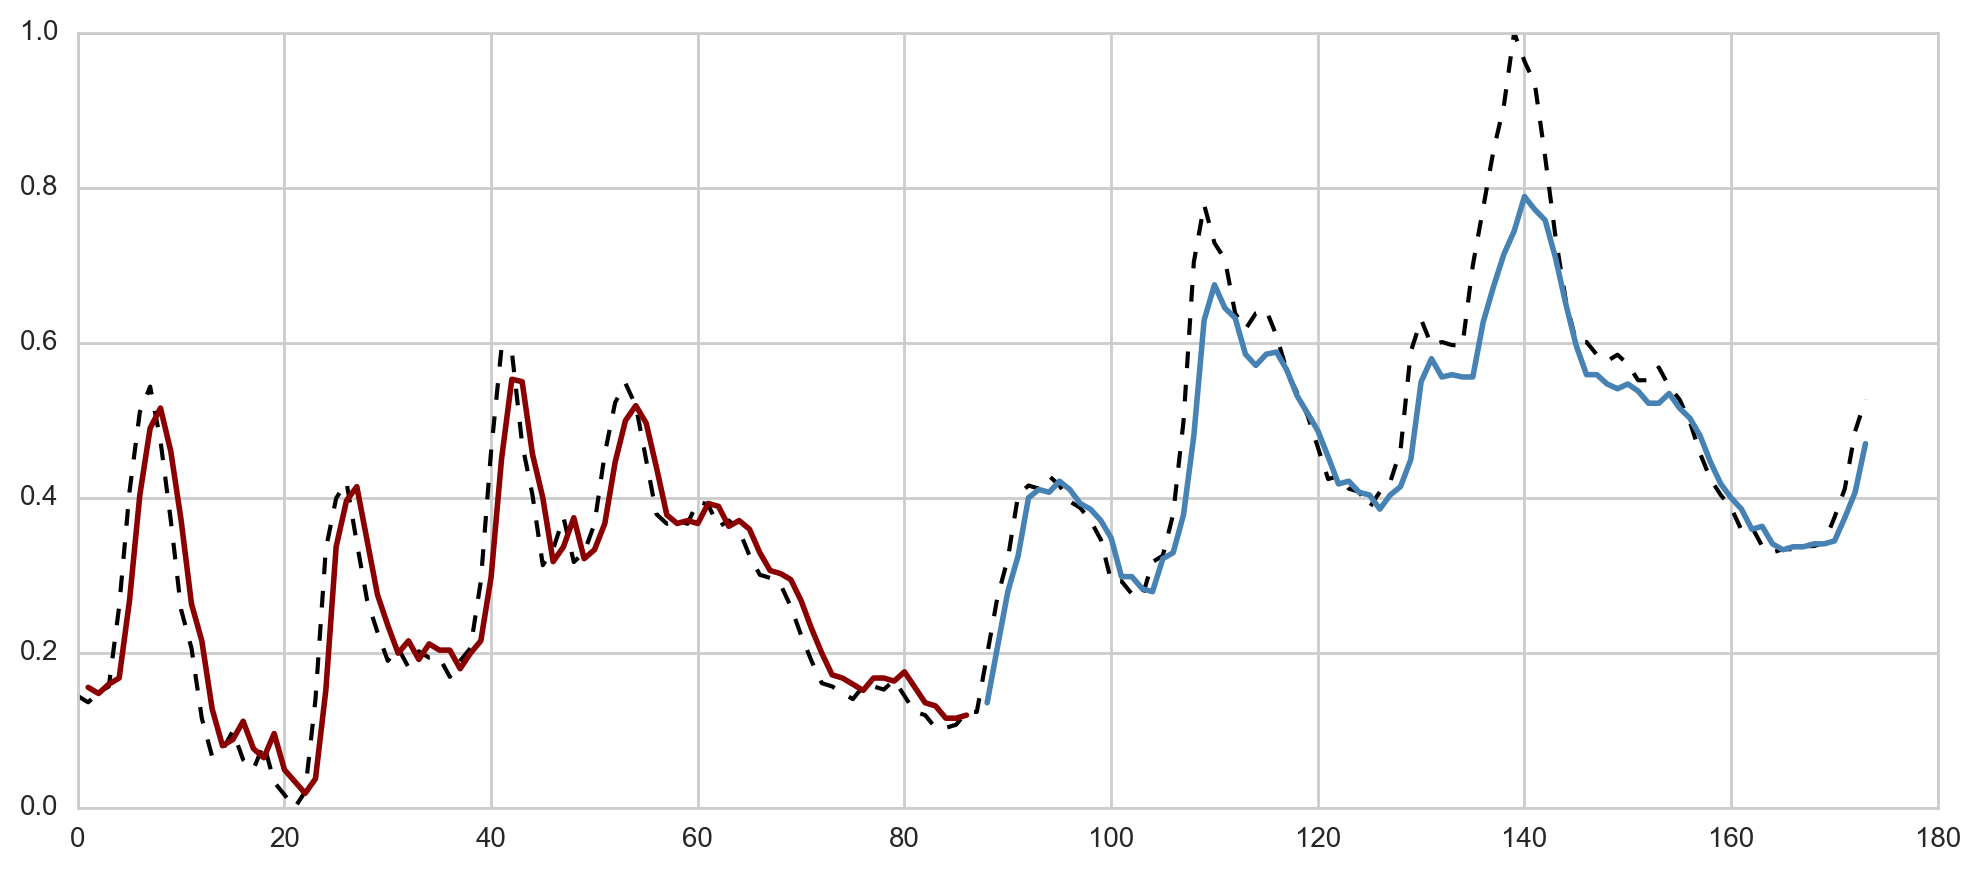

In [31]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(urate, lw=1.5, color='black', ls='dashed')
train_pred_plot = np.zeros(urate.shape)
train_pred_plot[:,:] = np.nan
train_pred_plot[1:(len(trainPredict)+1), :] = trainPredict

test_pred_plot = np.zeros(urate.shape)
test_pred_plot[:,:] = np.nan
test_pred_plot[(len(trainPredict)+2):, :] = testPredict

ax.plot(train_pred_plot, lw=2, color='darkred')
ax.plot(test_pred_plot, lw=2, color='steelblue')

plt.show()


---

### LSTM with multiple lags as predictors

We can instead  predict the unemployment rate from not just the rate prior, but the `t-1`, `t-2`, and `t-3` rates.

You can (purportedly) use the function you wrote above to construct a new X and Y where X now has 3 predictors according to the different lags.

Create the new Y and X variables below:

In [32]:
trainX, trainY = create_XY(train, lag=3)
testX, testY = create_XY(test, lag=3)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

---

### Construct and fit a Keras model with your new X and Y

In [33]:
model = Sequential()
model.add(LSTM(12, input_dim=3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
2s - loss: 0.0660
Epoch 2/100
0s - loss: 0.0204
Epoch 3/100
0s - loss: 0.0131
Epoch 4/100
0s - loss: 0.0118
Epoch 5/100
0s - loss: 0.0110
Epoch 6/100
0s - loss: 0.0102
Epoch 7/100
0s - loss: 0.0095
Epoch 8/100
0s - loss: 0.0087
Epoch 9/100
0s - loss: 0.0081
Epoch 10/100
0s - loss: 0.0076
Epoch 11/100
0s - loss: 0.0069
Epoch 12/100
0s - loss: 0.0064
Epoch 13/100
0s - loss: 0.0057
Epoch 14/100
0s - loss: 0.0055
Epoch 15/100
1s - loss: 0.0048
Epoch 16/100
0s - loss: 0.0043
Epoch 17/100
0s - loss: 0.0038
Epoch 18/100
0s - loss: 0.0037
Epoch 19/100
0s - loss: 0.0033
Epoch 20/100
0s - loss: 0.0030
Epoch 21/100
0s - loss: 0.0029
Epoch 22/100
0s - loss: 0.0028
Epoch 23/100
1s - loss: 0.0027
Epoch 24/100
0s - loss: 0.0026
Epoch 25/100
0s - loss: 0.0027
Epoch 26/100
0s - loss: 0.0026
Epoch 27/100
0s - loss: 0.0026
Epoch 28/100
0s - loss: 0.0025
Epoch 29/100
0s - loss: 0.0025
Epoch 30/100
0s - loss: 0.0025
Epoch 31/100
0s - loss: 0.0025
Epoch 32/100
0s - loss: 0.0025
Epoch 33/100
0s -

In [34]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

---

### Plot the predictions of the new model

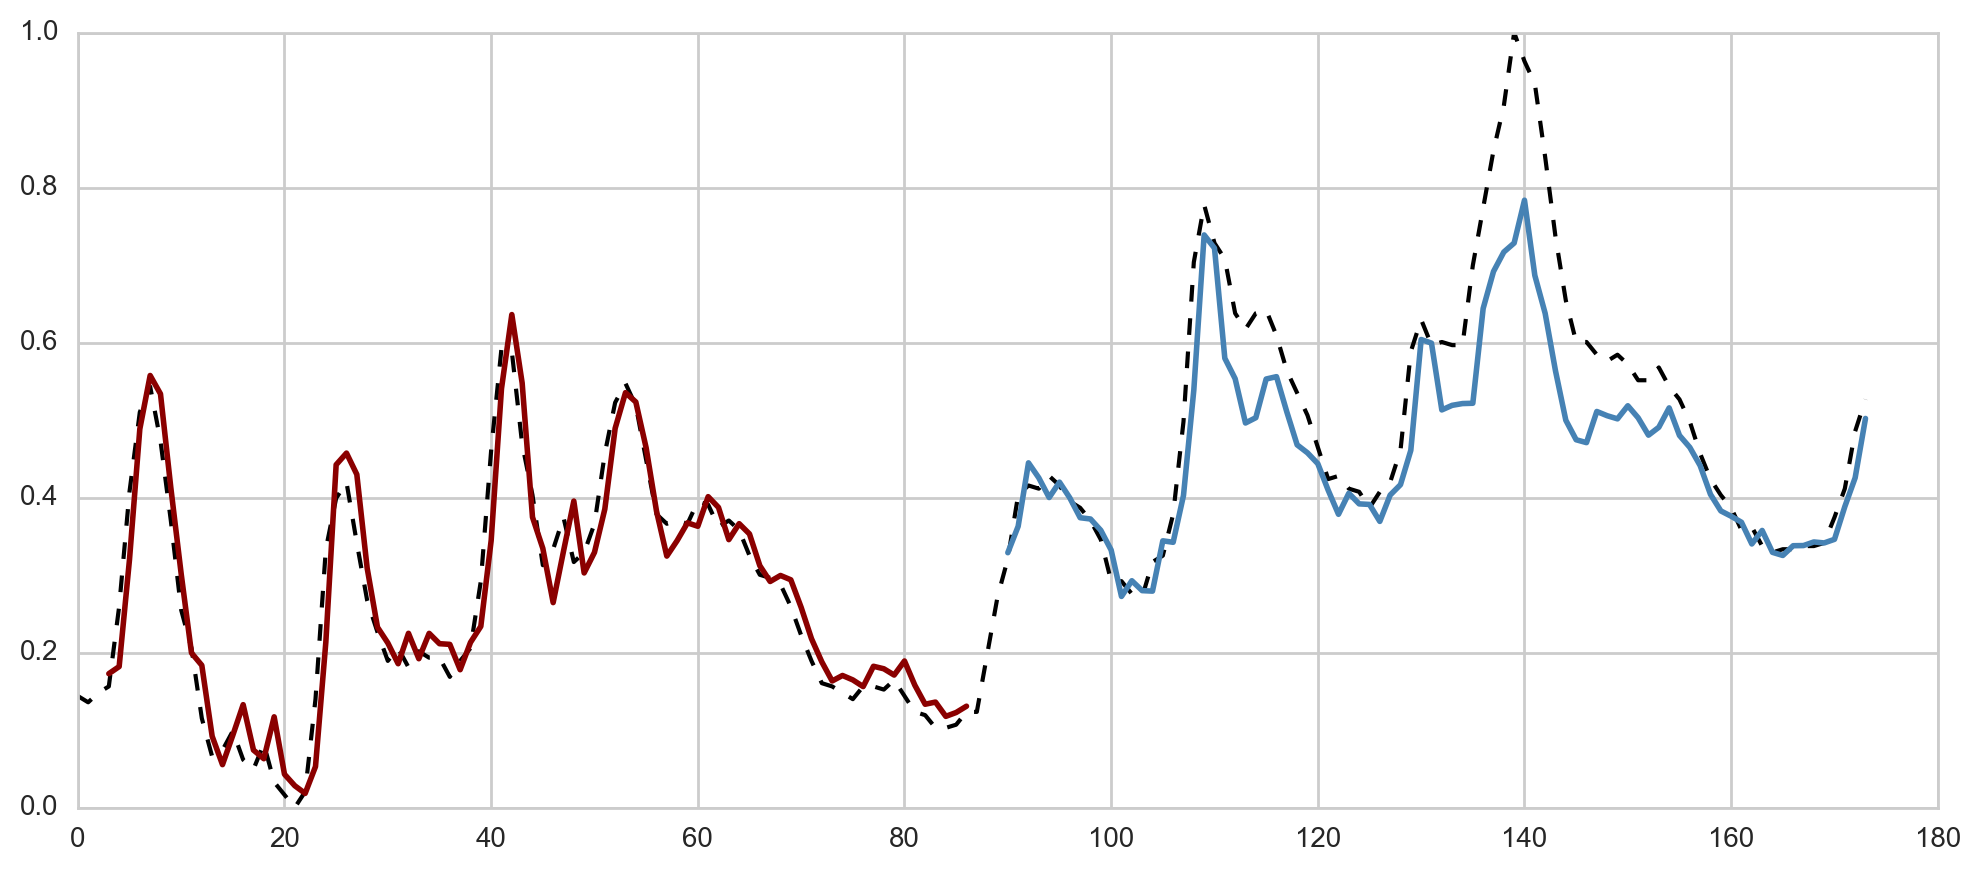

In [35]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(urate, lw=1.5, color='black', ls='dashed')
train_pred_plot = np.zeros(urate.shape)
train_pred_plot[:,:] = np.nan
train_pred_plot[3:(len(trainPredict)+3), :] = trainPredict

test_pred_plot = np.zeros(urate.shape)
test_pred_plot[:,:] = np.nan
test_pred_plot[(len(trainPredict)+6):, :] = testPredict

ax.plot(train_pred_plot, lw=2, color='darkred')
ax.plot(test_pred_plot, lw=2, color='steelblue')

plt.show()

---

### Rephrasing the problem with the "time steps" dimension

Recall that our X matrix is converted to the form:

    [samples, time steps, features]
    
In the model we just made, we were saying that we had 3 different features, each of 1 time step long. This works fine, but it would be more appropriate to say that we had 1 feature with three different time steps, since that's what the data actually is (the unemplyment rate lagged to different degrees).

Instead of reshaping our data where the time step dimension is 1, we can instead reshape it so that the feature dimension is 1 and the time step dimension is 3, like so:

```python
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
```

In this toy example, this will for all intents and purposes be the same, but it is more appropriate to specify it this way since the variable is the same.

Recreate your training and testing data but reshaping your lags on the time dimension rather than the feature dimension:

In [36]:
trainX, trainY = create_XY(train, lag=3)
testX, testY = create_XY(test, lag=3)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

---

### Rebuild and fit the LSTM model, and plot the predictions

In [37]:
model = Sequential()
model.add(LSTM(12, input_dim=1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
2s - loss: 0.0203
Epoch 2/100
1s - loss: 0.0107
Epoch 3/100
1s - loss: 0.0102
Epoch 4/100
1s - loss: 0.0094
Epoch 5/100
1s - loss: 0.0092
Epoch 6/100
1s - loss: 0.0092
Epoch 7/100
1s - loss: 0.0087
Epoch 8/100
1s - loss: 0.0085
Epoch 9/100
1s - loss: 0.0082
Epoch 10/100
1s - loss: 0.0080
Epoch 11/100
1s - loss: 0.0078
Epoch 12/100
1s - loss: 0.0077
Epoch 13/100
1s - loss: 0.0075
Epoch 14/100
1s - loss: 0.0072
Epoch 15/100
1s - loss: 0.0070
Epoch 16/100
1s - loss: 0.0069
Epoch 17/100
1s - loss: 0.0066
Epoch 18/100
1s - loss: 0.0065
Epoch 19/100
1s - loss: 0.0063
Epoch 20/100
1s - loss: 0.0059
Epoch 21/100
1s - loss: 0.0058
Epoch 22/100
1s - loss: 0.0055
Epoch 23/100
1s - loss: 0.0052
Epoch 24/100
1s - loss: 0.0051
Epoch 25/100
1s - loss: 0.0048
Epoch 26/100
1s - loss: 0.0045
Epoch 27/100
1s - loss: 0.0045
Epoch 28/100
1s - loss: 0.0041
Epoch 29/100
1s - loss: 0.0039
Epoch 30/100
1s - loss: 0.0038
Epoch 31/100
1s - loss: 0.0038
Epoch 32/100
1s - loss: 0.0035
Epoch 33/100
1s -

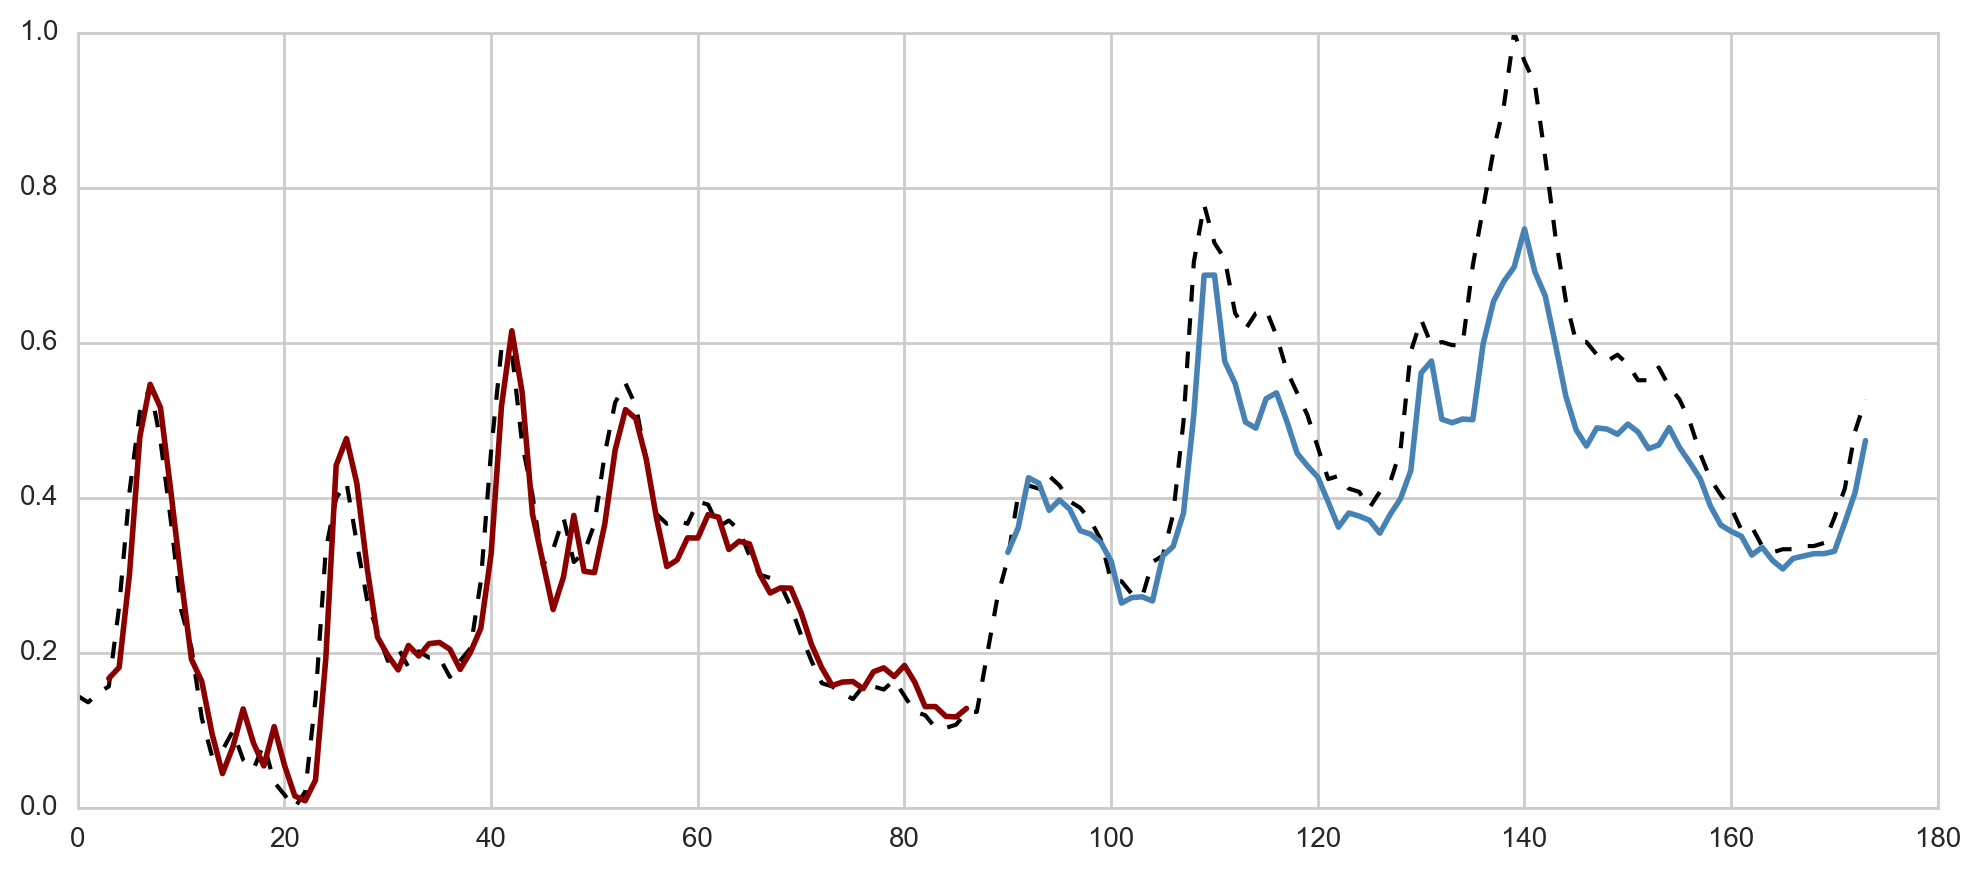

In [38]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

fig, ax = plt.subplots(figsize=(12,5))

ax.plot(urate, lw=1.5, color='black', ls='dashed')
train_pred_plot = np.zeros(urate.shape)
train_pred_plot[:,:] = np.nan
train_pred_plot[3:(len(trainPredict)+3), :] = trainPredict

test_pred_plot = np.zeros(urate.shape)
test_pred_plot[:,:] = np.nan
test_pred_plot[(len(trainPredict)+6):, :] = testPredict

ax.plot(train_pred_plot, lw=2, color='darkred')
ax.plot(test_pred_plot, lw=2, color='steelblue')

plt.show()

---

### Modeling financial data

Now we'll use LSTMs to model financial data. Matplotlib comes with a finance module that can pull historical stock prices for companies.

Below I've provided the code (taken from and sklearn example) for pulling a variety of companies opening and closing stock prices data for a specified range of dates.

In [39]:
from matplotlib.finance import quotes_historical_yahoo_ochl
import datetime

symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'MTU': 'Mitsubishi',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'Mc Donalds',
    'PEP': 'Pepsi',
    'MDLZ': 'Kraft Foods',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas instruments',
    'XRX': 'Xerox',
    'LMT': 'Lookheed Martin',
    'WMT': 'Wal-Mart',
    'WBA': 'Walgreen',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}

symbols, names = np.array(list(symbol_dict.items())).T

# Choose a time period (2008 crash in middle)
d1 = datetime.datetime(2007, 1, 1)
d2 = datetime.datetime(2009, 1, 1)

quotes = [quotes_historical_yahoo_ochl(symbol, d1, d2, asobject=True)
          for symbol in symbols]


stock_open = np.array([q.open for q in quotes]).astype(np.float)
stock_close = np.array([q.close for q in quotes]).astype(np.float)

# The daily variations of the quotes are what carry most information
variation = stock_close - stock_open

---

### Make a dataframe of the stock closing prices, with columns as the symbols and rows the days

---

### Plot the timeseries of closing prices for one of the companies

---

### Select just the companies that are banks

In [40]:
bank_names = {'WFC': 'Wells Fargo',
              'JPM': 'JPMorgan Chase',
              'AIG': 'AIG',
              'AXP': 'American express',
              'BAC': 'Bank of America',
              'GS': 'Goldman Sachs'}

---

### Scale the timeseries data for the companies with `MinMaxScaler`

---

### Write a function to prepare X and Y matrices for an LSTM 

We are going to try to predict the closing price of one of the banks using the lagged closing prices of the other banks (and if you want, the current bank as well, though that is not how I will do it in my example).

This will be similar to the function we wrote above, but now we are going to really make use of the 3D format for matrices going into an LSTM.

Recall that your X predictor matrix has the format:

    [samples, time steps, features]
    
In this case, each bank will be a feature, the "samples" will refer to which closing price you are predicting, and the time step dimension will be different lags of each feature. 

This takes awhile to wrap your head around, since we are thinking in 3D rather than 2D prediction matrices at this point. 

If wells fargo was a predictor, for example, and you wanted lag 1 and lag 2 to predict Goldman sachs, you would have:

    X[:, 0, wells_index] = data[wells fargo].shift(1).values[2:]
    X[:, 1, wells_index] = data[wells fargo].shift(2).values[2:]
    
I will be doing this kind of things for the different bank predictors using for loops.

---

### Create the X and Y and split into training and testing

---

### Fit and plot the LSTM model